# Extracting the Tangible Assets, and the year they relate to

## Method Overview

1.  Create a table of discovered sentences, inc. those that spread over two lines, and the coordinates of their bounding boxes.

2.  Identify isolated numeric values in the parsed text.

3.  For each value, subset the discovered sentences to those that are in-line with the value, and to the left.

4.  Somehow determine which of the numbers are those from the balance sheet, and what year they are for! (Work in progress)

5.  Separately extract years and their ordering, by looking for two year numbers in line with one year's difference and the older year on the right.  This is probably easier with this sparse table structure.

From UK National Accounts - A Short Guide:

"The national ccounts identifiy two types of asset within the economy. The first of
these is non-financial assets and includes fixed assets (buildings, vehicles,
machinery), valuables, inventories and non-produced assets (such as land). The
second type is financial assets. These include currency holdings, bank deposits,
ownership of shares and loans (from the point of view of the lender). Every financial
asset has an equal and opposite liability – in the examples above, the central bank is
liable for currency, the bank where the deposits are held, the share issuer and, in the
case of a loan, the borrower. "

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import pytesseract                            # API for letting python interface with Google's tesseract OCR software

import importlib

import xbrl_image_parser as xip


# -----------------------------------------------------------------
import re
import cv2                                    # Open Computer Vision library
import PyPDF2                                 # All things PDF format related
import io                                     # Something about messing with memory
from wand.image import Image                  # For messing with images
from PIL import Image as Im                   # Likewise images
import codecs                                 # Unknown

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.path import Path
from matplotlib.patches import PathPatch

from imageio import imread  # Lets me put an image into a plot

/home/martin/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## 1. Get the filenames of the example data for my convenience

In [2]:
# Get a list of all of the pdf files in the directory "CH_records"
files = [filename.split(".")[0] for filename in os.listdir("./working/ocr_output_compiled") if ".csv" in filename]

In [3]:
for each in range(len(files)):
    print(each, files[each])

0 00002404
1 868273
2 1983517
3 2765595
4 03293902
5 02959325
6 00542515
7 01539777
8 02714555
9 00030177
10 04802747
11 02266230
12 00983951
13 01002610
14 01804186
15 5508774
16 02430955
17 00053475
18 02245999
19 00553535
20 3387163
21 01337451
22 3459907
23 00178090
24 00468115
25 01369166
26 00782931
27 09457025
28 983951
29 01370175
30 06005142
31 04860660
32 2303730
33 02582534
34 00477955
35 04558828
36 06034603
37 3824626


## 2. Read in a csv file of data extracted from a PDF

Then perform some functions; calculating useful metadata about coordinates of discovered text, converting amenable text to numeric formats.

In [94]:
# Rediscovering what works...
importlib.reload(xip)
index=2

# So far can create all those extra geometric features, can convert to numeric
test = pd.read_csv("./working/ocr_output_compiled/"+files[index]+".csv")
line_test = xip.make_measurements(test)
line_test['numerical'] = xip.convert_to_numeric(line_test['text'])

# Drop all weird page-marking lines and such which have no text
line_test = line_test[line_test['conf'] != -1]

## 3. Create a table of discovered sentences and their coordinates

This table will contain all of the row labels from the balance sheet, as well as a LOT of other material

In [95]:
importlib.reload(xip)
#os.system("firefox " + "./example_data_PDF/" + files[index] + ".pdf" + " &")

agg_text = xip.aggregate_sentences_over_lines(line_test)

In [96]:
agg_text[agg_text['text'].apply(lambda x: "balancesheet" in x.lower())]

,block_num,bottom,csv_num,left,line_num,par_num,right,text,top
38,2.0,1892.0,3.0,488.0,7.0,2.0,733.0,balancesheet,1864.0
261,2.0,483.0,11.0,294.0,1.0,1.0,694.0,balancesheet,448.0
418,9.0,1455.0,15.0,389.0,1.0,1.0,2205.0,financialinstrumentsarerecognisedinthecompanys...,1377.0


## 4. Find sentences/labels that are in-line with discovered numbers

This should, therefore, contain all variables from the balance sheet

In [97]:
# Drop non-numeric entries
numeric_df = line_test.loc[line_test['numerical'].dropna().index,]

results = pd.DataFrame()

# Find matches
for index, row in numeric_df.iterrows():
    
    # Filter to all text that is left of, and starts level to or above, the number
    matched_text = agg_text[agg_text['csv_num'] == row['csv_num']]     # Filter to same source page
    matched_text = matched_text[matched_text['top'] < row['bottom']]   # No elements that start below number on page
    matched_text = matched_text[matched_text['bottom'] > row['top']]
    matched_text = matched_text[matched_text['right'] < row['left']]   # No elements to the right of the number
    
    #print(len(matched_text))
    # Sort the matches by distance upwards from number
    matched_text = matched_text.sort_values('top', ascending=False)
    
    # Handles issue where, with only one row left in matched_text, it becomes a series
    if len(matched_text) > 0:
        try:
            row['matched_texts'] = matched_text.iloc[0,:]['text']
            #print(row['numerical'], matched_text.iloc[0,:]['text'])
        except:
            row['matched_texts'] = matched_text['text']
            #print(row['numerical'], matched_text['text'])
    
        results = results.append(row)

## 5. Final step;  Filtering!

This is quite complicated.  The above steps produce a giant table of text-number pairs, wherever they were found in-line.  This contains the variables we seek, but also a lot of random crap extracted from elsewhere in the documents.  To deal with this we'll clean the data through a number of arbitrary filters designed to remove spurious matches.

In [98]:
# Define a function for detecting if a string is our balance sheet title
check_bs = lambda x: np.where( re.search( "^[abbreviated]*balancesheet", x ), True, False)

# Get a list of pages the title string/regex is found on
BS_page_list = pd.unique(agg_text[agg_text['text'].apply(check_bs)]['csv_num'])

# Filter results to those pages
results = results[results['csv_num'].apply(lambda x: x in BS_page_list)]

In [99]:
# Find the column header "^notes*$" (numbers are references to notes on financial accounts)
check_notes = lambda x: np.where( re.search( "^notes*$", str(x).lower() ), True, False)

# Get a table of entries that are that column header
note_entries = agg_text[agg_text['text'].apply(check_notes)]

# List and then drop every numeric entry aligned to left of discovered column header
to_drop = []
for index, row in note_entries.iterrows():
    temp_df = results[results['csv_num'] == row['csv_num']] # Filter to entries on relevant page
    temp_df = temp_df[temp_df['left'] < row['left']+90]     # Find numbers vertically aligned or to left of identified header
    to_drop = to_drop + list(temp_df.index)

results = results.drop(to_drop)

In [100]:
note_entries

,block_num,bottom,csv_num,left,line_num,par_num,right,text,top
247,4.0,764.0,10.0,1150.0,1.0,1.0,1253.0,notes,735.0
302,7.0,847.0,12.0,1396.0,1.0,1.0,1497.0,notes,817.0


In [101]:
# Filter numbers matched with "page" (page number!)
results = results[results['matched_texts'] != "page"]

# Filter numbers matched with "note" (column headers!)
results = results[results['matched_texts'].apply(lambda x: not np.where( re.search( "^notes*$", x ), True, False))]

In [102]:
# Filter out any page with the words "notes to the financial statements"
exc_page_list = pd.unique(agg_text[agg_text['text'].apply(lambda x: "notestothefinancialstatements" in x)]['csv_num'])
results = results[results['csv_num'].apply(lambda x: x not in exc_page_list)]

In [103]:
# Filter out any page with the words "Statement of changes in equity"
exc_page_list = pd.unique(agg_text[agg_text['text'].apply(lambda x: "statementof" in x)]['csv_num'])
results = results[results['csv_num'].apply(lambda x: x not in exc_page_list)]

In [104]:
results[['text', 'numerical', 'matched_texts']]

,text,numerical,matched_texts
2927,2017,2017.0,asatjanuary
3018,11,11.0,stocks
3020,12,12.0,debtors
3024,15,15.0,calledupsharecapital
3043,"4,470,000",4470000.0,goodwill
3046,"758,410",758410.0,tangibleassets
3051,"38,614,590",38614590.0,stocks
3053,"6,635,985",6635985.0,debtors
3055,"3,863,767",3863767.0,cashatbankandinhand
3059,"(38,409,179)",38409179.0,creditorsamountsfallingduewithioneyear


## 6. Get an example of a variable

For "creditors", we get all four relevant numbers from the balance sheet and no other (spurious) variables from elsewhere.  Likewise for "tangible".  The left-most value for each pair of variables (the one with the lowers "left" coordinate) will be that of the most recent year.

In [105]:
results[results['matched_texts'].apply(lambda x: "credit" in x)][['csv_num', 'numerical', 'matched_texts', 'left', 'top']]

,csv_num,numerical,matched_texts,left,top
3059,11.0,38409179.0,creditorsamountsfallingduewithioneyear,1232.0,1410.0
3094,11.0,37117733.0,creditorsamountsfallingduewithioneyear,1750.0,1410.0


In [106]:
results[results['matched_texts'].apply(lambda x: "tangible" in x)][['csv_num', 'numerical', 'matched_texts', 'left', 'top']]

,csv_num,numerical,matched_texts,left,top
3046,11.0,758410.0,tangibleassets,1555.0,928.0
3100,11.0,649811.0,tangibleassets,2071.0,928.0


### How many unique labels are left?

In [107]:
print(len(results['matched_texts'].unique()))

results_counts = results.groupby('matched_texts').agg('count')['word_num']

bad_egg_list = list(results_counts[results_counts != 2].index)

13


In [108]:
results[ [x not in bad_egg_list for x in results['matched_texts']] ][['matched_texts', 'text', 'numerical']]

,matched_texts,text,numerical
3043,goodwill,"4,470,000",4470000.0
3046,tangibleassets,"758,410",758410.0
3055,cashatbankandinhand,"3,863,767",3863767.0
3059,creditorsamountsfallingduewithioneyear,"(38,409,179)",38409179.0
3062,netcurrentassets,"10,705,163",10705163.0
3065,totalassetslesscurrentliabilities,"15,933,573",15933573.0
3071,profitandlossreserves,"15,933,473",15933473.0
3075,totalequity,"15,933,573",15933573.0
3087,cashatbankandinhand,"5,517,998",5517998.0
3094,creditorsamountsfallingduewithioneyear,"(37,117,733)",37117733.0


In [109]:
# Did we get the right pages?
pd.unique(results['csv_num'])

array([11.])

# PLOTTING DIAGNOSTICS - Finding out if the blocking algorithm is truly unreliable

In [17]:
# Figure out the ratio of whitespace in each block

def calculate_whitespace(data, threshold=0.8):
    
    # to hold calculated values
    whitespace = []
    block_num = []
    csv_num = []
    whitespace_frac = []
    whitespace_anomalous = []

    for csv in data['csv_num'].unique():
        for block in data[data['csv_num']==csv]['block_num'].unique():
            
            subset = data[(data['csv_num']==csv) & (data['block_num']==block)]      # Get the relevant data
            total_area = subset[subset['par_num']==0]['area'].sum()                 # Total area of block
            word_area = subset[subset['word_num'] > 0]['area'].sum()                # Total area occupied by words (assume rectangles)
            whitespace.append(total_area - word_area)                               # Therefore total area whitespace
            csv_num.append(csv)
            block_num.append(block)
            fraction = total_area - word_area / total_area                     # Finally, fraction whitespace
            whitespace_frac.append(fraction)   
            
            # Decide if it's anomalous or not following threshold (between 0 and 0.99)
            whitespace_anomalous.append((fraction > threshold) & (fraction < 0.99 ))
            
    whitespace_data = pd.DataFrame({"whitespace":whitespace,
                                    "whitespace_frac":whitespace_frac,
                                    "whitespace_anomalous":whitespace_anomalous,
                                    "block_num":block_num,
                                    "csv_num":csv_num})
    
    return( data.merge(whitespace_data, on=["csv_num", "block_num"], how="left") )

In [18]:
# Plotting commands

def create_path_patches(line_data, csv_num):
    
    line_data=line_data[line_data['csv_num']==csv_num].reset_index()
    
    # For storing all of the created pathpatches
    path_patches = []

    # Need the height and width of the image to create the canvas
    image_length = line_data.loc[0]['height']
    image_width = line_data.loc[0]['width']

    #sample = line_data[line_data['line_num'] == 0]
    sample = line_data
    sample = sample.drop(0)
    # Iterate through the samples
    for index, row in sample.iterrows():
    
        # Define the shape by specifying its corners, remember
        # x-y coords start at BOTTOM LEFT of image
        vertices = [(row['left'], row['top']),      # Top left
                     (row['left'], row['bottom']),   # Bottom left
                     (row['right'], row['bottom']),  # Bottom right
                     (row['right'], row['top']),     # Top right
                     (0, 0)]                                        # Blank for closing off the polygon automatically
        # Codify instructions to path tracer for 
        codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
    
        # Face colour, based on whether the whitespace is anomalous
        face_colour = str(np.where(row['whitespace_anomalous']==True, "red", "green"))
    
        # Line colour, based on whether the word spacing is anomalous
        #line_colour = str(np.where(row['word_spacing_anomalous']==True, "red", "green"))

        # Convert gathered information to a path
        path_patches.append( {"path":Path(vertices, codes),
                              "face_colour":face_colour,
                              "line_colour": "green"} )
    
    return(path_patches, vertices)

In [19]:
def plot_doc(path_patches, vertices, filepath):

    # Plot the lot!
    fig, ax = plt.subplots(figsize=(270, 100))
    for each in path_patches:
        ax.add_patch(PathPatch(each['path'],
                               facecolor = each['face_colour'],
                               edgecolor=each['line_colour'],
                               lw=3,
                               alpha=0.3))
    
    ax.set_title("Discovered blocks")

    ax.dataLim.update_from_data_xy(vertices)
    ax.autoscale_view()

    plt.imshow(imread(filepath), cmap="gray")
    plt.savefig("./output_graphical/discovered_blocks.png")
    plt.show()

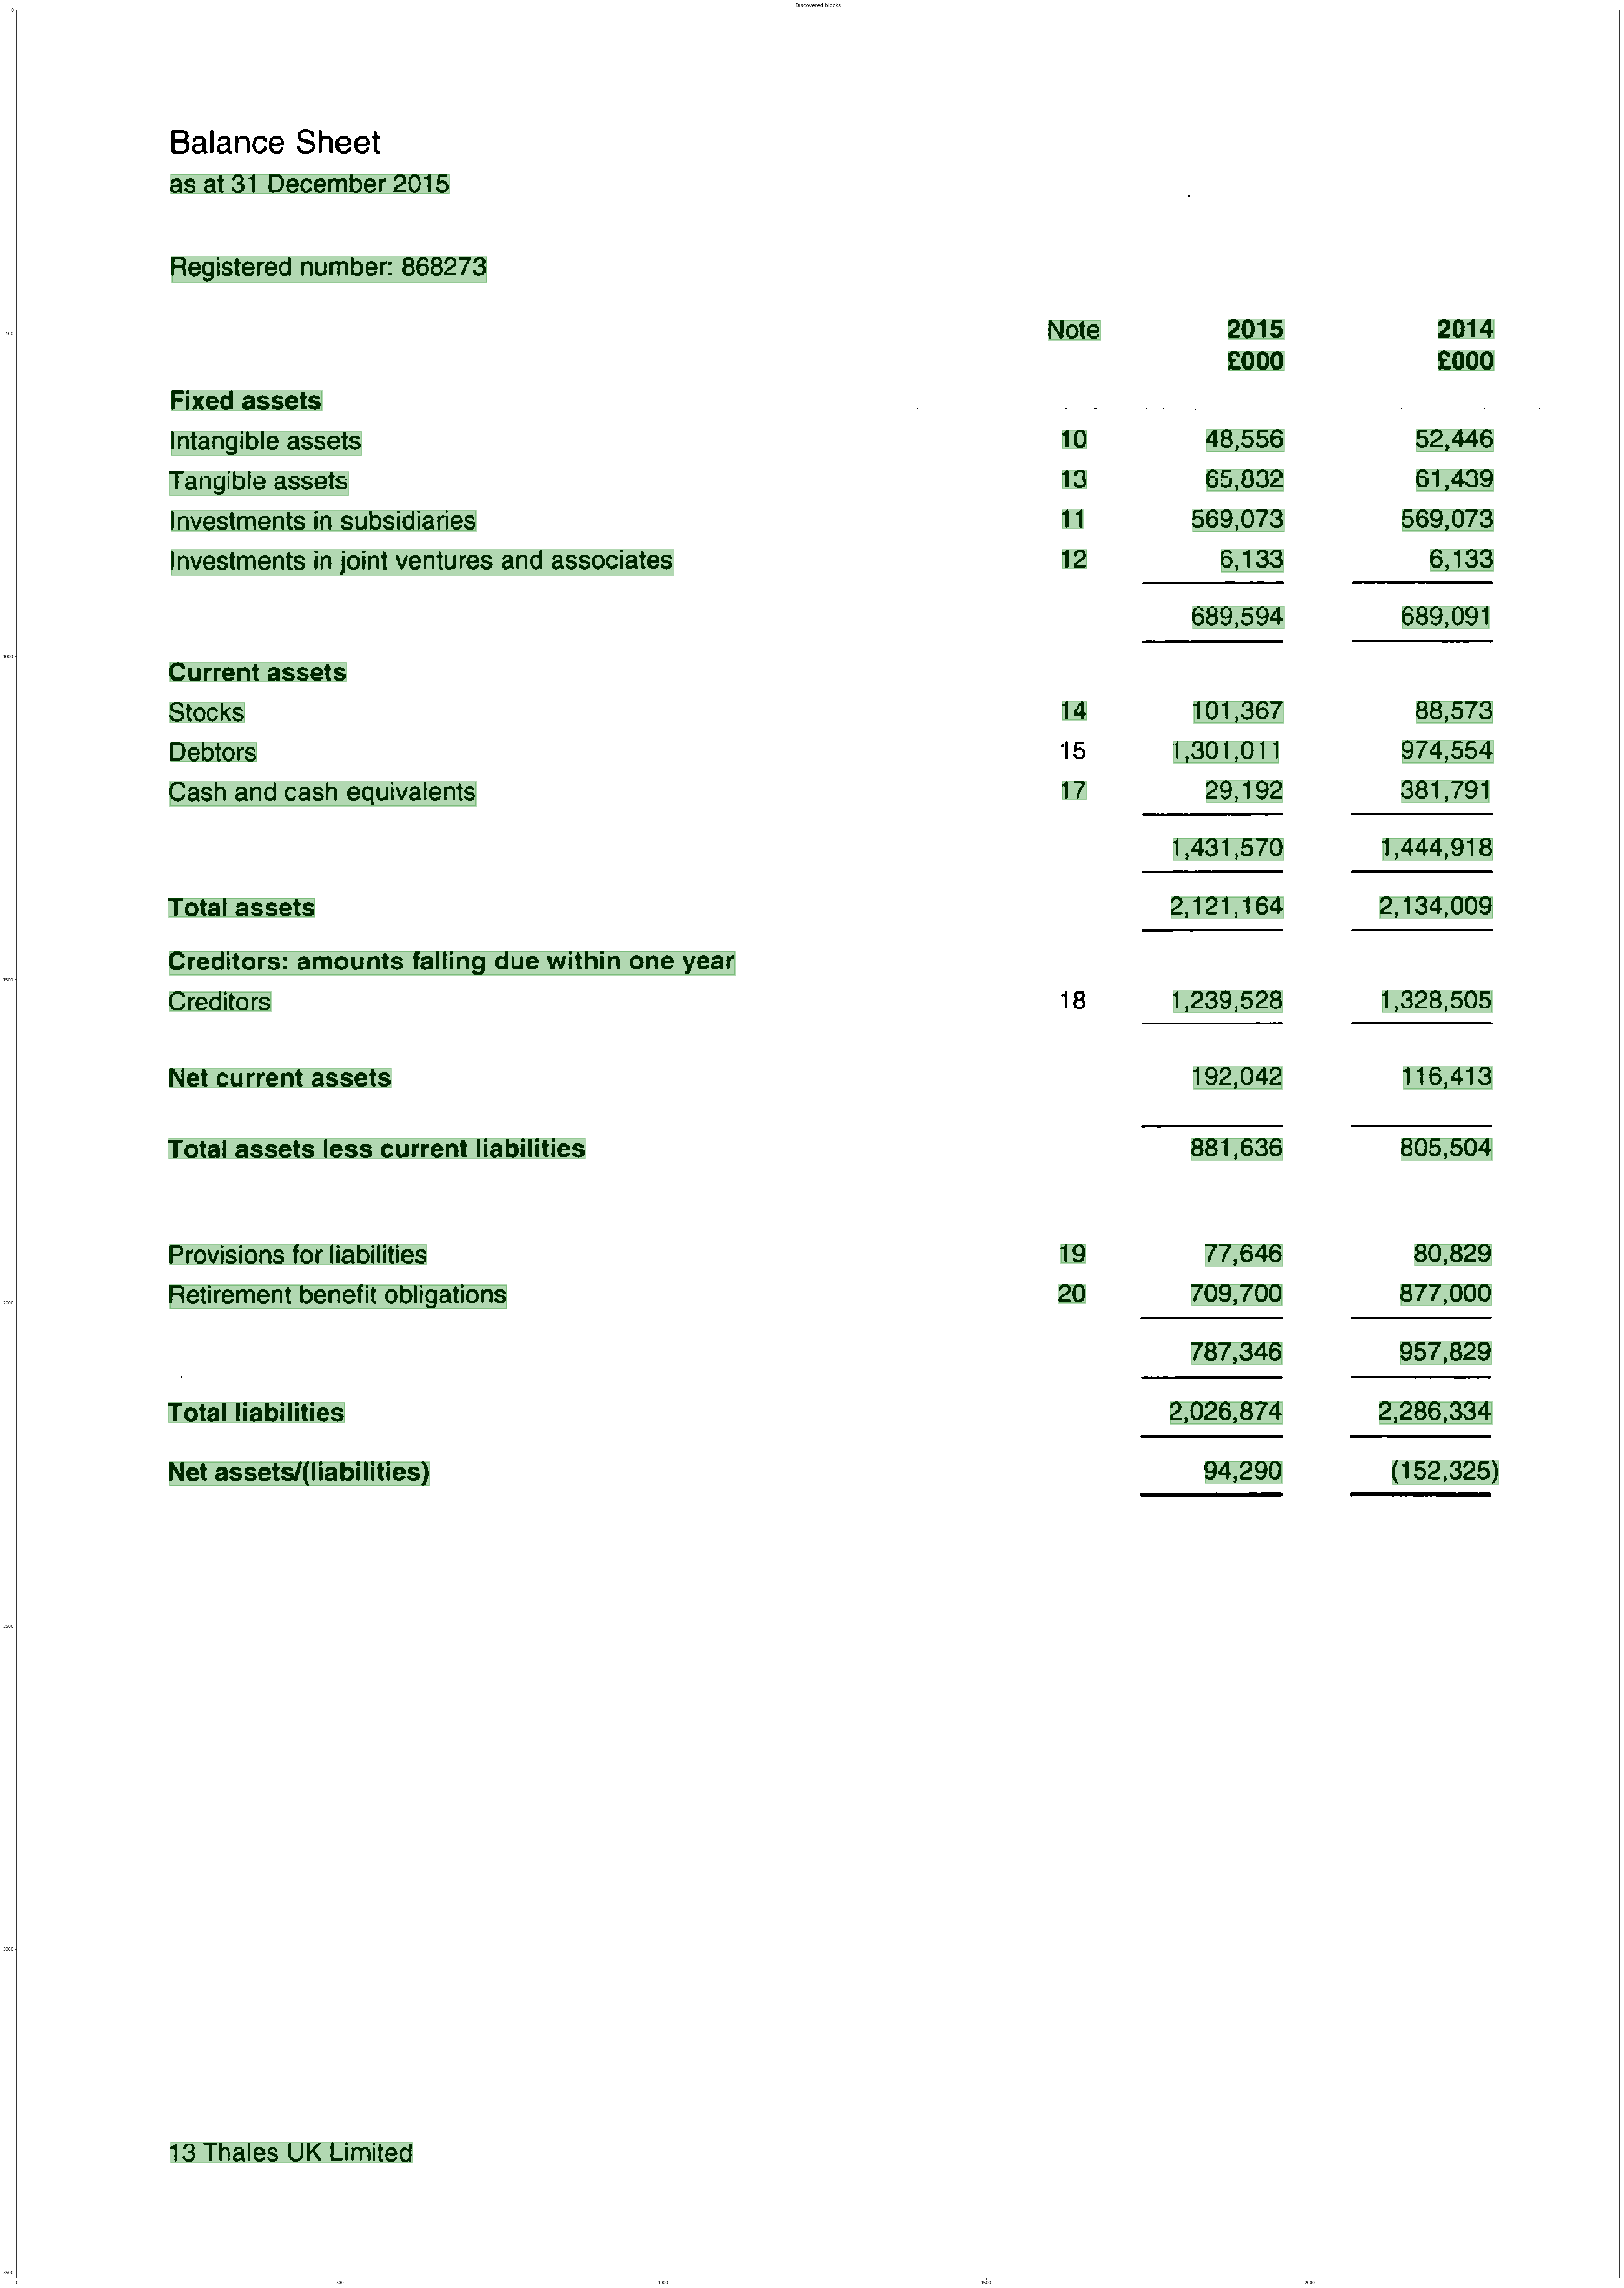

In [20]:
# Pick the file and page to plot
file_index=1
csv_num=15

# Pick the block level to portray
level=4

# Do all the maths
white_test=calculate_whitespace(xip.make_measurements(pd.read_csv("./working/ocr_output_compiled/"+files[file_index]+".csv")))

# Define the boxes to plot
path_patches, vertices = create_path_patches(white_test[white_test['level']==level], csv_num=csv_num)

# Draw everything up for inspection
plot_doc(path_patches, vertices, "./working/preprocessed/"+files[file_index]+"-"+str(csv_num)+".png")